# Load data

In [1]:
import ast
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pycode_similar
import re
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler


from base64 import b64decode
def decode_program(code):
    return b64decode(code).decode("utf-8")

In [2]:
exercise_df = pd.read_csv("exercise.csv")
ipython = exercise_df[exercise_df["name"] == "IPython"]

log_df = pd.read_csv('data/umimeprogramovatcz-ipython_log.csv', sep=';')
questions_df = pd.read_csv('data/umimeprogramovatcz-ipython_item.csv', sep=';', index_col='id')
log_df.drop(list(range(424)), inplace=True)
log_df.reset_index(inplace=True, drop=True)

## Exercise dataframe

In [3]:
exercise_df.head()

,id,name,short,type,questions,log,column,dropMode,hasRT,sumTime,globalMaxTime,doBoxplot,sortCriterium,fromTime
0,1,Doplňovačka stará,xxx,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0,0,NaN
1,2,Otázky staré,yyy,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0,0,NaN
2,3,Diktáty,diktaty,medal,dictate.csv,dictate_session_log.csv,dictate,NaN,0.0,0.0,0.0,0,0,NaN
3,4,Čárky,carky,medal,carky_sentence.csv,carky_sentence_log.csv,sentence,NaN,0.0,0.0,0.0,0,0,NaN
4,5,Rozbory,rozbory,medal,vetne_cleny_sentence.csv,vetne_cleny_log.csv,sentence,NaN,1.0,0.0,0.0,0,0,2018-01-01


## IPython record (from exercise_df)

In [4]:
ipython

,id,name,short,type,questions,log,column,dropMode,hasRT,sumTime,globalMaxTime,doBoxplot,sortCriterium,fromTime
33,35,IPython,ipython,item,ipython_item.csv,ipython_log.csv,item,keep_only_last,1.0,0.0,1.0,1,ordering,2018-02-21


## Log dataframe

In [5]:
log_df.head(10)

,id,user,item,answer,correct,moves,responseTime,time
0,1966,1625382,13,ZGVmIHN0cmluZ19pbnRlcnNlY3Rpb24obGVmdCwgcmlnaH...,1,-1,423250,2017-12-06 15:12:17
1,1967,1625382,14,ZGVmIHBhbGluZHJvbSh0ZXh0KTpicmVhayAgICBpZiBsZW...,1,-1,730000,2017-12-06 16:10:43
2,1976,1518209,31,ZGVmIGZpbmRfbG9uZ2VzdF93b3JkKHdvcmRzX2xpc3QpOm...,0,-1,28350,2017-12-06 17:44:30
3,1977,1518209,31,ZGVmIGZpbmRfbG9uZ2VzdF93b3JkKHdvcmRzX2xpc3QpOm...,0,-1,55100,2017-12-06 17:44:57
4,1979,1518209,31,ZGVmIGZpbmRfbG9uZ2VzdF93b3JkKHdvcmRzX2xpc3QpOm...,0,-1,151500,2017-12-06 17:46:33
5,1980,1518209,31,ZGVmIGZpbmRfbG9uZ2VzdF93b3JkKHdvcmRzX2xpc3QpOm...,0,-1,193900,2017-12-06 17:48:45
6,1981,1518209,31,ZGVmIGZpbmRfbG9uZ2VzdF93b3JkKHdvcmRzX2xpc3QpOm...,0,-1,194850,2017-12-06 17:48:46
7,1982,1518209,31,ZGVmIGZpbmRfbG9uZ2VzdF93b3JkKHdvcmRzX2xpc3QpOm...,0,-1,195700,2017-12-06 17:48:47
8,1983,1518209,31,ZGVmIGZpbmRfbG9uZ2VzdF93b3JkKHdvcmRzX2xpc3QpOm...,0,-1,196300,2017-12-06 17:48:47
9,1984,1518209,31,ZGVmIGZpbmRfbG9uZ2VzdF93b3JkKHdvcmRzX2xpc3QpOm...,0,-1,196650,2017-12-06 17:48:48


In [67]:
log_df = log_df.drop_duplicates(['user', 'item', 'answer', 'correct'])

## Questions dataframe

In [6]:
questions_df.head(16)

,name,instructions,democode,testcode,solution,tests,medianTime,ordering,visible,created
id,,,,,,,,,,
1,Výpis čísel,"[[""html"",""Napište funkci <b>numbers(n)</b>, kt...","[[""python64"",""ZGVmIG51bWJlcnMobik6CiAgICBwcmlu...","[[""python64"",""bnVtYmVycygxMCkK""]]","[[""python64"",""ZGVmIG51bWJlcnMobik6CiAgICBmb3Ig...","[[""python64"",""bnVtYmVycygzKQo=""],[""python64"",""...",136380,1,1,2017-11-21 18:17:19
2,Fibonacciho posloupnost,"[[""html"",""Napište funkci <b>fibonacci(n)</b>, ...","[[""python64"",""ZGVmIGZpYm9uYWNjaShuKToKICAgIGZv...","[[""python64"",""Zmlib25hY2NpKDEwKQo=""]]","[[""python64"",""ZGVmIGZpYm9uYWNjaShuKToKICAgIGN1...","[[""python64"",""Zmlib25hY2NpKDUpCg==""],[""python6...",136380,7,1,2017-11-21 18:17:19
3,Faktoriál,"[[""html"",""Napište funkci <b>factorial(n)</b> v...","[[""python64"",""ZGVmIGZhY3RvcmlhbChuKToKICAgIHJl...","[[""python64"",""cHJpbnQoZmFjdG9yaWFsKDUpKQo=""]]","[[""python64"",""ZGVmIGZhY3RvcmlhbChuKToKICAgIHZh...","[[""python64"",""cHJpbnQoZmFjdG9yaWFsKDYpKQo=""],[...",136380,7,1,2017-11-21 18:17:19
4,Abeceda,"[[""html"",""Napište funkci <b>alphabet(n)</b>, k...","[[""python64"",""ZGVmIGFscGhhYmV0KG4pOgogICAgZm9y...","[[""python64"",""YWxwaGFiZXQoMzApCg==""]]","[[""python64"",""ZGVmIGFscGhhYmV0KG4pOgogICAgZm9y...","[[""python64"",""YWxwaGFiZXQoMTApCg==""],[""python6...",136380,10,1,2017-11-21 18:17:19
5,Zdvojení znaků,"[[""html"",""Napište funkci <b>duplication(text)<...","[[""python64"",""ZGVmIGR1cGxpY2F0aW9uKHRleHQpOgog...","[[""python64"",""cHJpbnQoZHVwbGljYXRpb24oIlBZVEhP...","[[""python64"",""ZGVmIGR1cGxpY2F0aW9uKHRleHQpOgog...","[[""python64"",""cHJpbnQoZHVwbGljYXRpb24oIkFBIikp...",193233,3,1,2017-11-21 18:17:19
6,Součin nenulových,"[[""html"",""Napište funkci <b>nonzero_product(nu...","[[""python64"",""ZGVmIG5vbnplcm9fcHJvZHVjdChudW1i...","[[""python64"",""cHJpbnQobm9uemVyb19wcm9kdWN0KFs0...","[[""python64"",""ZGVmIG5vbnplcm9fcHJvZHVjdChudW1i...","[[""python64"",""cHJpbnQobm9uemVyb19wcm9kdWN0KFsw...",149201,2,1,2017-11-21 18:17:19
7,Dělitelé,"[[""html"",""Napište funkci <b>divisors(n)</b>, k...","[[""python64"",""ZGVmIGRpdmlzb3JzKG4pOgogICAgcHJp...","[[""python64"",""ZGl2aXNvcnMoMjQpCg==""]]","[[""python64"",""ZGVmIGRpdmlzb3JzKG4pOgogICAgZm9y...","[[""python64"",""ZGl2aXNvcnMoNSkK""],[""python64"",""...",193233,1,1,2017-11-21 18:17:19
8,Čtverec,"[[""html"",""Napište funkci <b>square(n)</b>, kte...","[[""python64"",""ZGVmIHNxdWFyZShuKToKICAgIGZvciBp...","[[""python64"",""c3F1YXJlKDUpCg==""]]","[[""python64"",""ZGVmIHNxdWFyZShuKToKICAgIGZvciBp...","[[""python64"",""c3F1YXJlKDMpCg==""],[""python64"",""...",193233,1,1,2017-11-21 18:17:19
9,Prázdný čtverec,"[[""html"","" Napište funkci <b>empty_square(n)</...","[[""python64"",""ZGVmIGVtcHR5X3NxdWFyZShuKToKICAg...","[[""python64"",""ZW1wdHlfc3F1YXJlKDUpCg==""]]","[[""python64"",""ZGVmIGVtcHR5X3NxdWFyZShuKToKICAg...","[[""python64"",""ZW1wdHlfc3F1YXJlKDYpCg==""],[""pyt...",193233,2,1,2017-11-21 18:17:19


In [7]:
questions_df.at[1, 'testcode'][2:-2].split(',')[1].replace('"', '')

'bnVtYmVycygxMCkK'

# Filter only decodable answers

In [8]:
valid = ['True' for _ in range(log_df.shape[0])]
log_df['valid'] = valid

for index, answer in log_df['answer'].items():
    try:
        decode_program(answer)
    except:
        log_df.at[index, 'valid'] = 'False'

In [9]:
log_df = log_df[log_df['valid'] == 'True']
log_df['code'] = log_df.answer.apply(decode_program)

## Filtered log dataframe
Also drop 'valid' column and add 'codeLength' column.

In [10]:
log_df.drop('valid', axis=1, inplace=True)

In [11]:
def get_code_length(code):
    length = code.count("break") + code.count("\n")
    if code.count("\n") > 0:
        length += 1
    return length

log_df['codeLength'] = log_df.code.apply(get_code_length)

In [12]:
log_df.reset_index(inplace=True, drop=True)
log_df.head(10)

,id,user,item,answer,correct,moves,responseTime,time,code,codeLength
0,1976,1518209,31,ZGVmIGZpbmRfbG9uZ2VzdF93b3JkKHdvcmRzX2xpc3QpOm...,0,-1,28350,2017-12-06 17:44:30,def find_longest_word(words_list):break ret...,2
1,1977,1518209,31,ZGVmIGZpbmRfbG9uZ2VzdF93b3JkKHdvcmRzX2xpc3QpOm...,0,-1,55100,2017-12-06 17:44:57,def find_longest_word(words_list):break ret...,2
2,1979,1518209,31,ZGVmIGZpbmRfbG9uZ2VzdF93b3JkKHdvcmRzX2xpc3QpOm...,0,-1,151500,2017-12-06 17:46:33,def find_longest_word(words_list):break,1
3,1980,1518209,31,ZGVmIGZpbmRfbG9uZ2VzdF93b3JkKHdvcmRzX2xpc3QpOm...,0,-1,193900,2017-12-06 17:48:45,def find_longest_word(words_list):break,1
4,1981,1518209,31,ZGVmIGZpbmRfbG9uZ2VzdF93b3JkKHdvcmRzX2xpc3QpOm...,0,-1,194850,2017-12-06 17:48:46,def find_longest_word(words_list):break,1
5,1982,1518209,31,ZGVmIGZpbmRfbG9uZ2VzdF93b3JkKHdvcmRzX2xpc3QpOm...,0,-1,195700,2017-12-06 17:48:47,def find_longest_word(words_list):break,1
6,1983,1518209,31,ZGVmIGZpbmRfbG9uZ2VzdF93b3JkKHdvcmRzX2xpc3QpOm...,0,-1,196300,2017-12-06 17:48:47,def find_longest_word(words_list):break,1
7,1984,1518209,31,ZGVmIGZpbmRfbG9uZ2VzdF93b3JkKHdvcmRzX2xpc3QpOm...,0,-1,196650,2017-12-06 17:48:48,def find_longest_word(words_list):break,1
8,1985,1518209,31,YnJlYWs=,0,-1,264550,2017-12-06 17:49:56,break,1
9,1986,1518209,31,YnJlYWs=,0,-1,272200,2017-12-06 17:50:03,break,1


# Statistics


In [13]:
g_min = log_df.groupby("item").min().add_suffix('Min')
g_mean = log_df.groupby("item").mean().add_suffix('Mean')
g_max = log_df.groupby("item").max().add_suffix('Max')

In [14]:
stats_df = pd.concat([g_min, g_mean, g_max], axis=1, sort=False)
stats_df = stats_df[['correctMean', 'responseTimeMin', 'responseTimeMean', 'responseTimeMax',
                    'codeLengthMin', 'codeLengthMean', 'codeLengthMax']]
stats_df['numAnswers'] = log_df.groupby("item").count()["id"]
stats_df.reset_index(inplace=True)
stats_df.responseTimeMean = stats_df.responseTimeMean.round().astype(int)
stats_df.codeLengthMean = stats_df.codeLengthMean.round().astype(int)

In [15]:
stats_df.sort_values(by=['correctMean'])

,item,correctMean,responseTimeMin,responseTimeMean,responseTimeMax,codeLengthMin,codeLengthMean,codeLengthMax,numAnswers
34,36,0.188288,900,120816,4772300,0,6,525,1349
32,34,0.208728,550,159622,16110100,0,4,352,5385
3,4,0.242958,900,682957,11681250,0,7,36,284
61,63,0.276799,2050,179551,3751250,0,5,17,1987
28,30,0.308511,4900,742133,5621100,3,12,39,188
52,54,0.321016,850,406966,31106600,2,7,19,1299
43,45,0.337484,1350,159116,3871900,2,5,25,803
49,51,0.363470,2150,374334,22561150,2,6,18,1095
67,69,0.370370,3850,1287850,8715850,3,19,49,108
16,17,0.374368,2850,447331,5652050,1,9,151,593


In [16]:
stats_df.sort_values(by=['numAnswers'])

,item,correctMean,responseTimeMin,responseTimeMean,responseTimeMax,codeLengthMin,codeLengthMean,codeLengthMax,numAnswers
72,74,0.463415,3400,2077005,9200850,4,17,56,41
37,39,0.481928,4500,3054973,88672800,3,14,51,83
71,73,0.571429,7550,1212375,5179600,4,15,50,91
70,72,0.578431,2850,569144,2900200,2,12,25,102
67,69,0.370370,3850,1287850,8715850,3,19,49,108
26,28,0.438017,5950,833443,7135800,1,13,23,121
18,19,0.522727,8650,797658,8551650,3,13,38,132
42,44,0.595745,6950,411541,2666550,3,6,13,141
11,12,0.397436,5050,1172605,13651500,1,11,38,156
22,23,0.654762,2900,767793,7800100,2,9,46,168


# Plots
Following graphs (statistics) are computed from every solution attempt, not only final solutions.

### Success rate

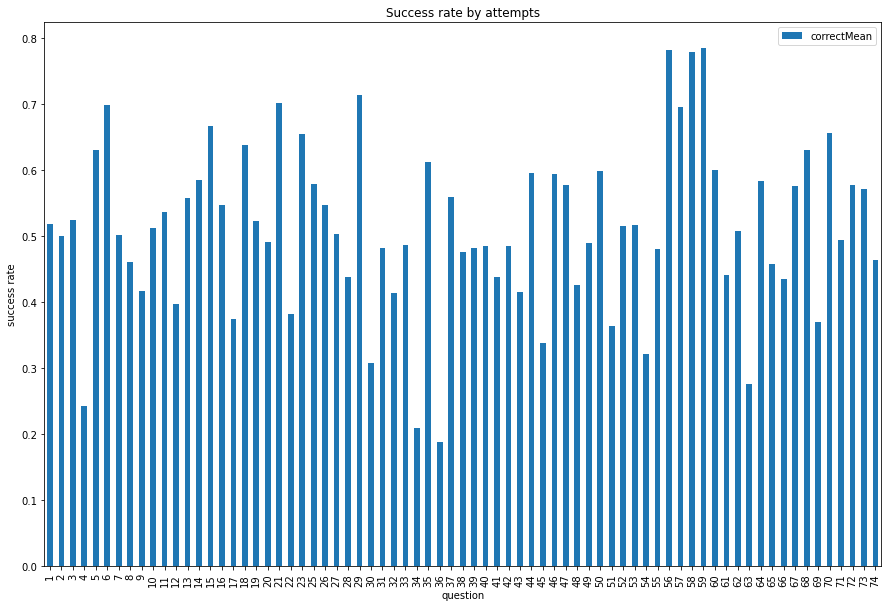

In [17]:
ax = plt.gca()

stats_df.plot(kind='bar', x='item', y='correctMean', title='Success rate by attempts', figsize=(15, 10), ax=ax)

ax.set_ylabel('success rate')
ax.set_xlabel('question')
plt.show()

### Response time
Minimum, average and maximum response time for each question.

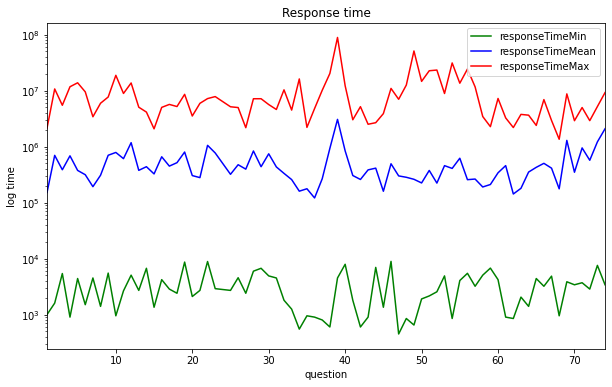

In [18]:
ax = plt.gca()

stats_df.plot(kind='line', x='item', y='responseTimeMin', color='green', logy=True, figsize=(10, 6),
              title="Response time", ax=ax) 
stats_df.plot(kind='line', x='item', y='responseTimeMean', color='blue', logy=True, ax=ax)
stats_df.plot(kind='line', x='item', y='responseTimeMax', color='red', logy=True, ax=ax)

ax.set_ylabel('log time')
ax.set_xlabel('question')
plt.show()

### Code length in lines
Lowest, average and highest number of lines for each question.

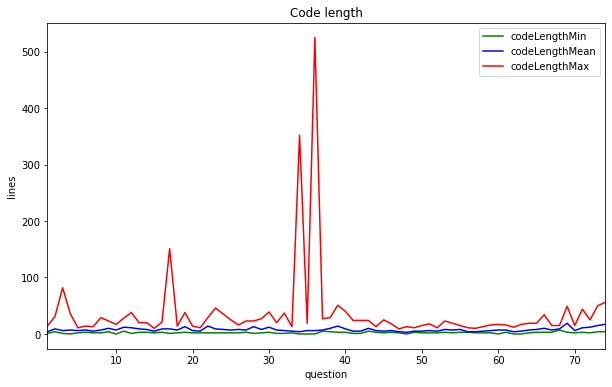

In [19]:
ax = plt.gca()

stats_df.plot(kind='line', x='item', y='codeLengthMin', color='green', figsize=(10, 6), title="Code length", ax=ax) 
stats_df.plot(kind='line', x='item', y='codeLengthMean', color='blue', ax=ax)
stats_df.plot(kind='line', x='item', y='codeLengthMax', color='red', ax=ax)

ax.set_ylabel('lines')
ax.set_xlabel('question')
plt.show()

## Features

In [20]:
# def, print, loop, ifelse, math, compare, assign
features_names = ['def', 'print', 'loop', 'ifelse', 'math', 'compare', 'assign']
features_regex = ['def ', 'print\(', 'for |while ', '\sif |\selif |\selse:', 
            '[^"](\+|\-|\*|/|\+\+|\-\-|%)[^"]', '[^"](<|<=|>|>=|==| is )[^"]', '[^=\+\-\*/"]=[^="]']

# tSNE

In [21]:
scaler = StandardScaler()
pca = PCA()

def decode_ast(solution):
    try:
        ast.parse(solution)
        return True
    except Exception:
        return False

In [45]:
def compute_features(item, correct_only=False, incorrect_only=False):
    task_df = log_df[log_df['item'] == item]
    if correct_only:
        task_df = task_df[task_df['correct'] == 1]
    elif incorrect_only:
        task_df = task_df[task_df['correct'] == 0]
    solution = questions_df.at[item, 'solution'][2:-2].split(',')[1].replace('"', '')
    solution = decode_program(solution)
    
    # Find ast-parsable solutions
    parsed = task_df.code.apply(decode_ast)
    
    # Pick only ast-parsable solutions
    task_df = pd.DataFrame(task_df[parsed])
    
    # Compute similarity to solution code
    similarities = pycode_similar.detect([solution, *task_df.code.values])
    sim_perc = np.array([x[1][0].plagiarism_percent for x in similarities])
    task_df["sim_perc_sol"] = sim_perc
    
    # Compute answer's ast length (abstract syntax tree)
    ast_len = []
    
    for x in similarities:
        if x[1][0].info_candidate is not None:
            ast_len.append(len(x[1][0].info_candidate.func_ast_lines))
        else:
            ast_len.append(0)
            
    task_df['ast_len'] = ast_len
    
    # Compute similarity to closest correct answer
    correct_codes = task_df[task_df['correct'] == 1].code.values.tolist()
    correct_codes.append(solution)
    sim_perc_closest = []
    feature_dict = {}
    for regex in features_regex:
        feature_dict[regex] = []
    
    for index, row in task_df.iterrows():
        if row['correct'] == 1:
            sim_perc_closest.append(1)
        else:
            try:
                similarities = pycode_similar.detect([row['code'], *correct_codes])
                sim_perc = [x[1][0].plagiarism_percent for x in similarities]
                closest = max(sim_perc)
            except:
                closest = 0
            sim_perc_closest.append(closest)
            
        # Get feature vectors
        for feature in feature_dict:
            feature_count = len(re.findall(feature, row['code']))
            feature_dict[feature].append(feature_count)
    
    # Add new columns
    task_df['sim_perc_closest'] = sim_perc_closest
    
    for regex, name in zip(features_regex, features_names):
        task_df[name] = feature_dict[regex]
    
    return task_df

### tSNE on all solutions

Colored by similarity to closest corrent solution

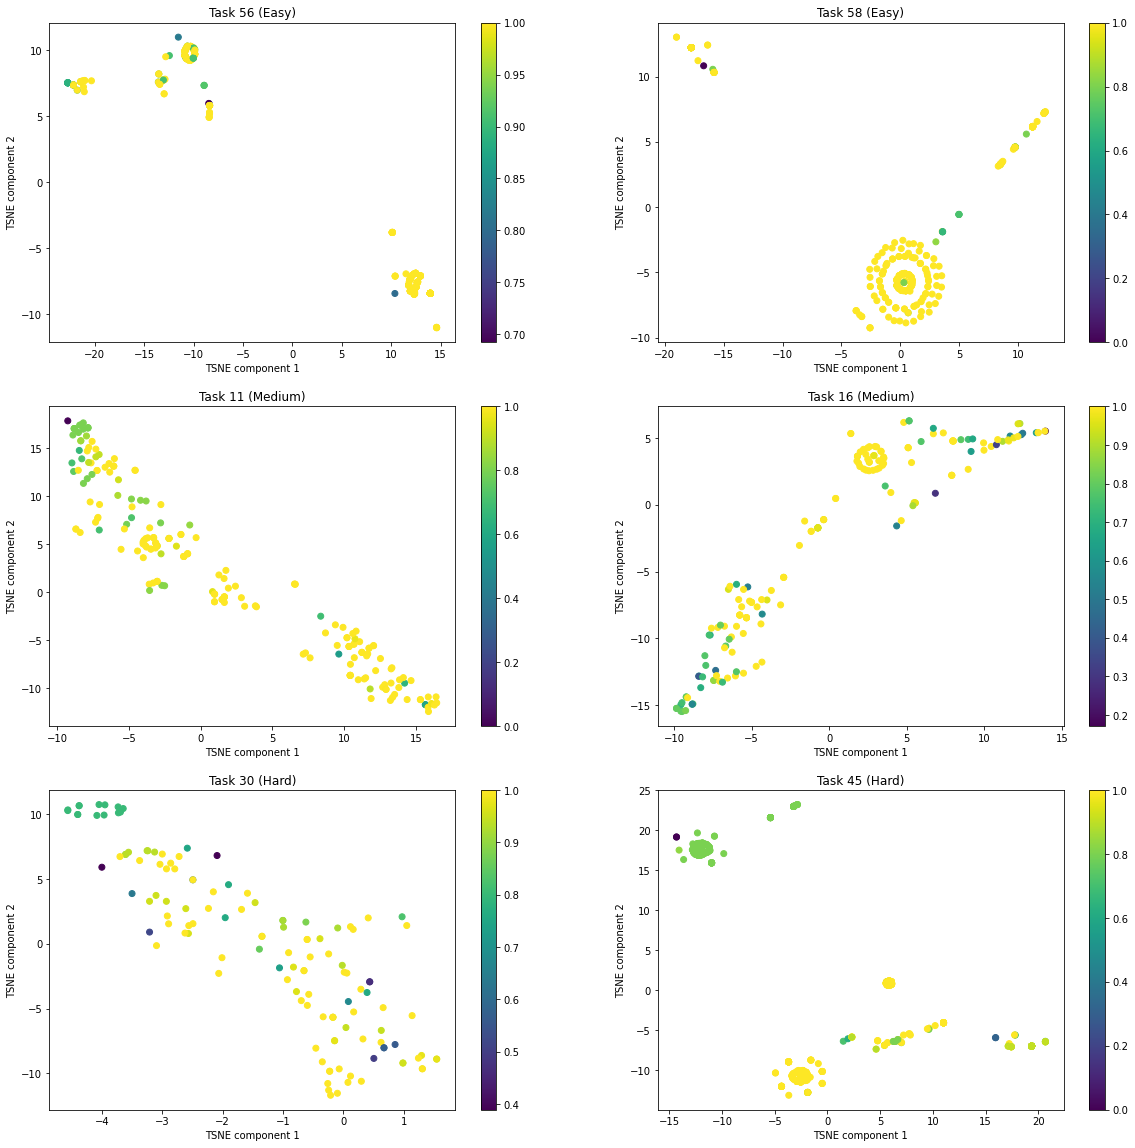

In [68]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 20))

for item, dif, plt_row, plt_col in zip([56, 58, 11, 16, 30, 45],
                                       ["Easy", "Easy", "Medium", "Medium", "Hard", "Hard"],
                                       [0, 0, 1, 1, 2, 2],
                                       [0, 1, 0, 1, 0, 1]):
    task_df = compute_features(item)
            
    # Drop unnecessary columns
    correct = task_df.correct
    task_df_trimmed = task_df.drop(['id', 'item', 'user', 'time', 'answer', 'code', 'moves', 'responseTime', 
                                    'correct', 'codeLength', 'sim_perc_sol', 'sim_perc_closest'],
                                    axis=1)
    
    # TSNE
    X_embedded = TSNE(n_components=2).fit_transform(task_df_trimmed.values)
    vector0 = [x[0] for x in X_embedded]
    vector1 = [x[1] for x in X_embedded]
    
    ax = axes[plt_row, plt_col]
    im = ax.scatter(x=vector0, y=vector1, c=task_df['sim_perc_closest'])
    ax.set_title("Task {} ({})".format(item, dif))
    ax.set_ylabel('TSNE component 2')
    ax.set_xlabel('TSNE component 1')
    fig.colorbar(im, ax=ax)

plt.show()

### tSNE on correct solutions only

Colored by similarity to the example solution

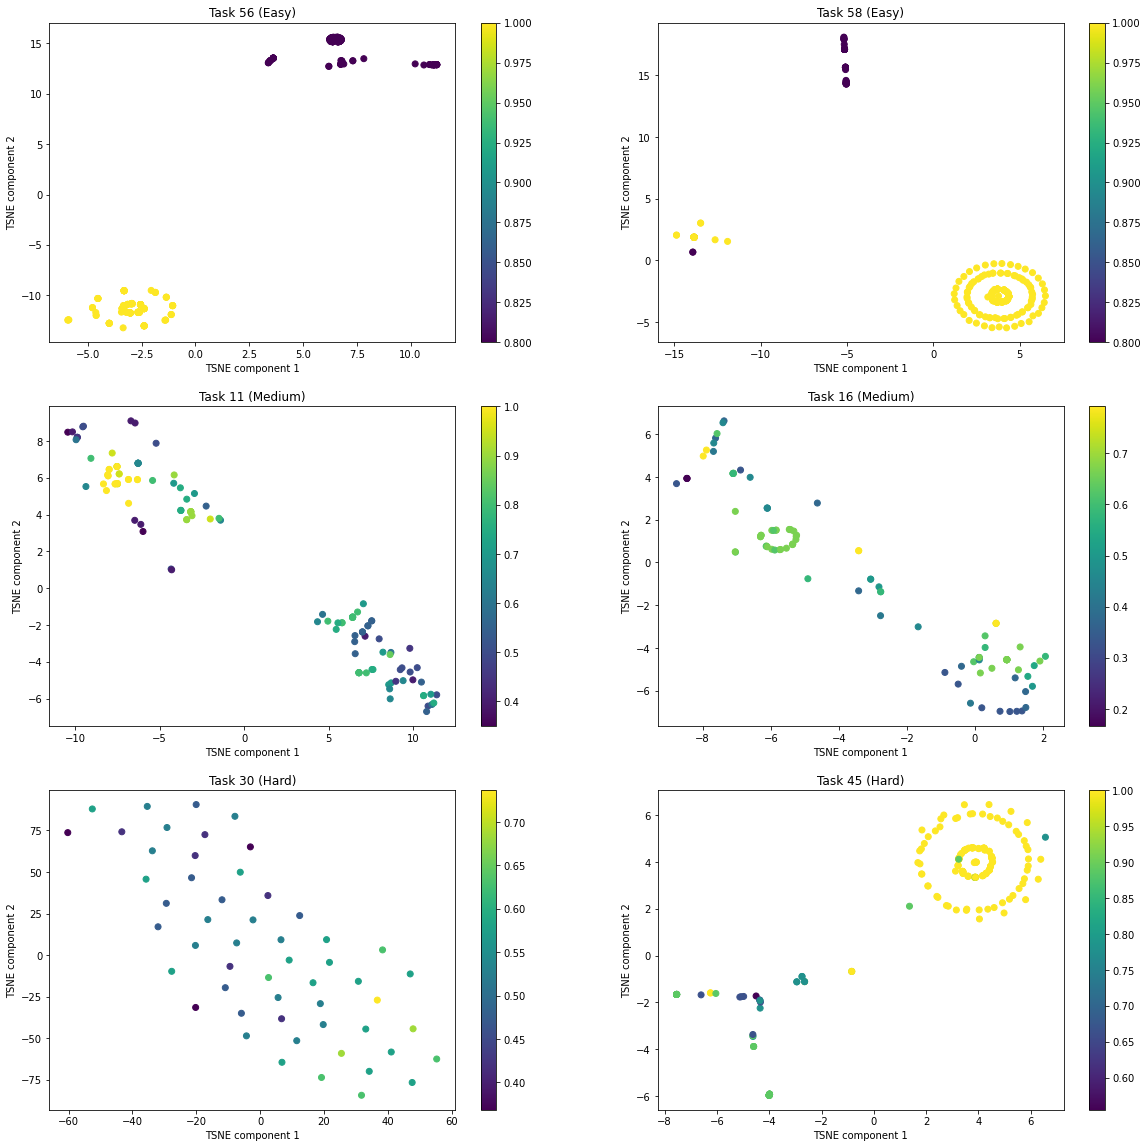

In [69]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 20))

for item, dif, plt_row, plt_col in zip([56, 58, 11, 16, 30, 45],
                                       ["Easy", "Easy", "Medium", "Medium", "Hard", "Hard"],
                                       [0, 0, 1, 1, 2, 2],
                                       [0, 1, 0, 1, 0, 1]):
    task_df = compute_features(item, correct_only=True)
    
    # Drop unnecessary columns
    task_df_trimmed = task_df.drop(['id', 'item', 'user', 'time', 'answer', 'code', 'moves', 'responseTime', 
                                    'correct', 'codeLength', 'sim_perc_sol', 'sim_perc_closest'],
                                    axis=1)
    
    # TSNE
    X_embedded = TSNE(n_components=2).fit_transform(task_df_trimmed.values)
    vector0 = [x[0] for x in X_embedded]
    vector1 = [x[1] for x in X_embedded]
    
    ax = axes[plt_row, plt_col]
    im = ax.scatter(x=vector0, y=vector1, c=task_df['sim_perc_sol'])
    ax.set_title("Task {} ({})".format(item, dif))
    ax.set_ylabel('TSNE component 2')
    ax.set_xlabel('TSNE component 1')
    fig.colorbar(im, ax=ax)

plt.show()

# PCA

### What happens here:

Extract few features about each record in task.

Use PCA on these features.

Plot top 2 PCA components in scatter plot.

The colour in plots represents the 'correct' column in the dataframe - whether the answer was correct or not. Yellow points are correct answers, dark point are incorrect answers.

## Difficulty based on success rate
I picked two tasks for each difficulty level.

Easy: 56, 58, 57, 70

Medium: 11, 16, 33, 42

Hard: 30, 45, 34, 36

One set: [56, 58, 11, 16, 30, 45]   Other set: [57, 70, 33, 42, 34, 36]

### PCA on all solutions

Colored by similarity to closest correct solution

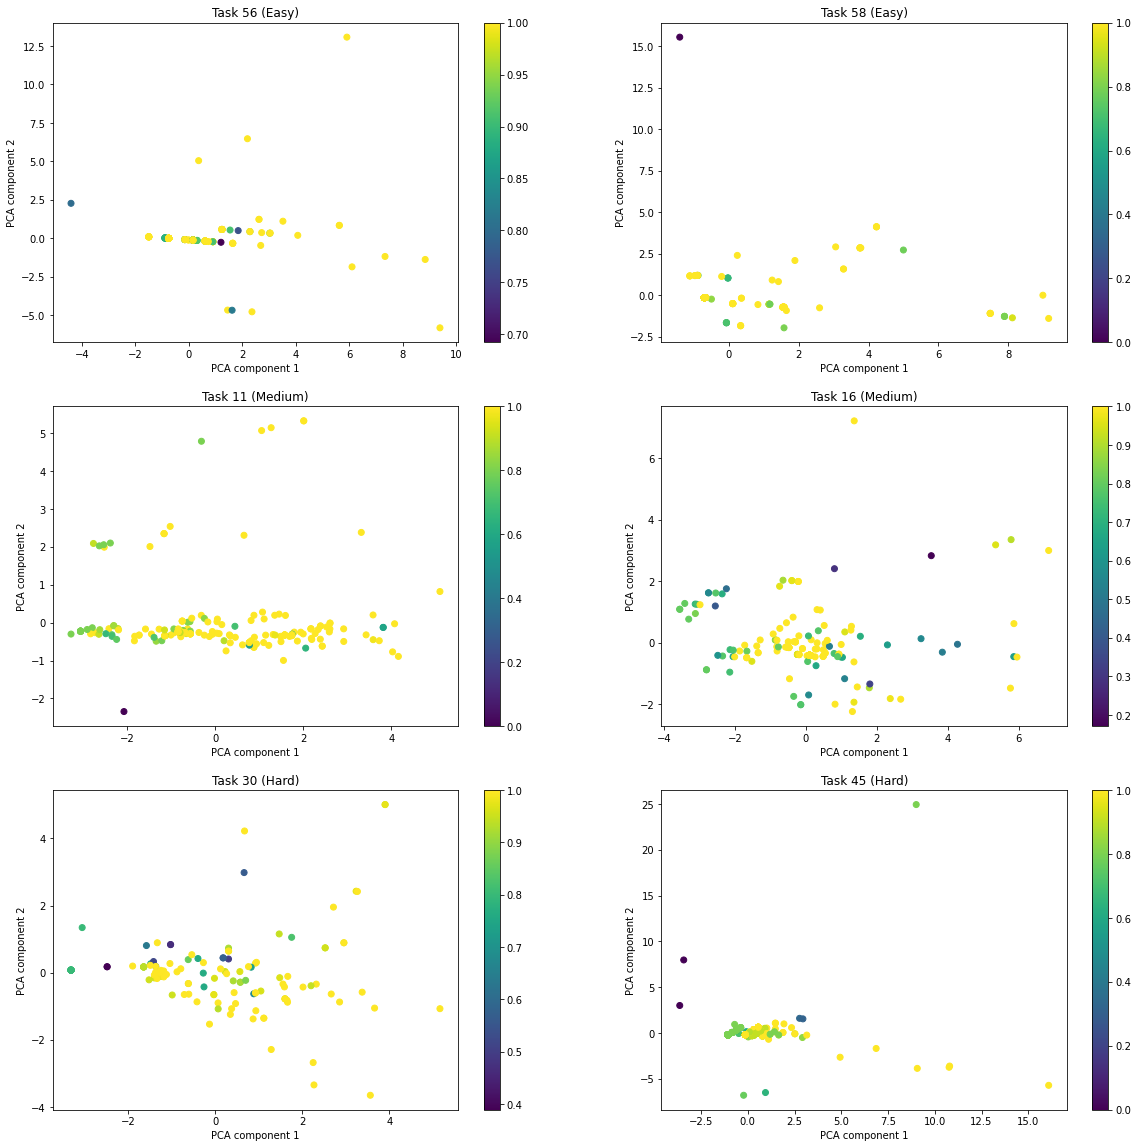

In [70]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 20))

for item, dif, plt_row, plt_col in zip([56, 58, 11, 16, 30, 45],
                                       ["Easy", "Easy", "Medium", "Medium", "Hard", "Hard"],
                                       [0, 0, 1, 1, 2, 2],
                                       [0, 1, 0, 1, 0, 1]):
    task_df = compute_features(item)
            
    # Drop unnecessary columns
    task_df_trimmed = task_df.drop(['id', 'item', 'user', 'time', 'answer', 'code', 'moves', 'responseTime', 
                                    'correct', 'codeLength', 'sim_perc_sol', 'sim_perc_closest'],
                                    axis=1)
    
    # Scale the columns and perform pca
    pca_components = pca.fit_transform(scaler.fit_transform(task_df_trimmed[[x for x in task_df_trimmed.columns]]))
    
    # Plot
    ax = axes[plt_row, plt_col]
    im = ax.scatter(*pca_components.T[:2], c=task_df['sim_perc_closest'])
    ax.set_title("Task {} ({})".format(item, dif))
    ax.set_ylabel('PCA component 2')
    ax.set_xlabel('PCA component 1')
    fig.colorbar(im, ax=ax)

plt.show()

In [27]:
task_df_trimmed.head()

,ast_len,def,print,loop,ifelse,math,compare,assign
563,5,1,1,1,0,0,0,0
564,5,1,1,1,0,0,0,0
565,5,1,1,1,0,0,0,0
592,9,1,1,1,0,1,0,0
654,11,1,1,1,1,3,1,2


## PCA on correct solutions only

Colored by similarity to example solution

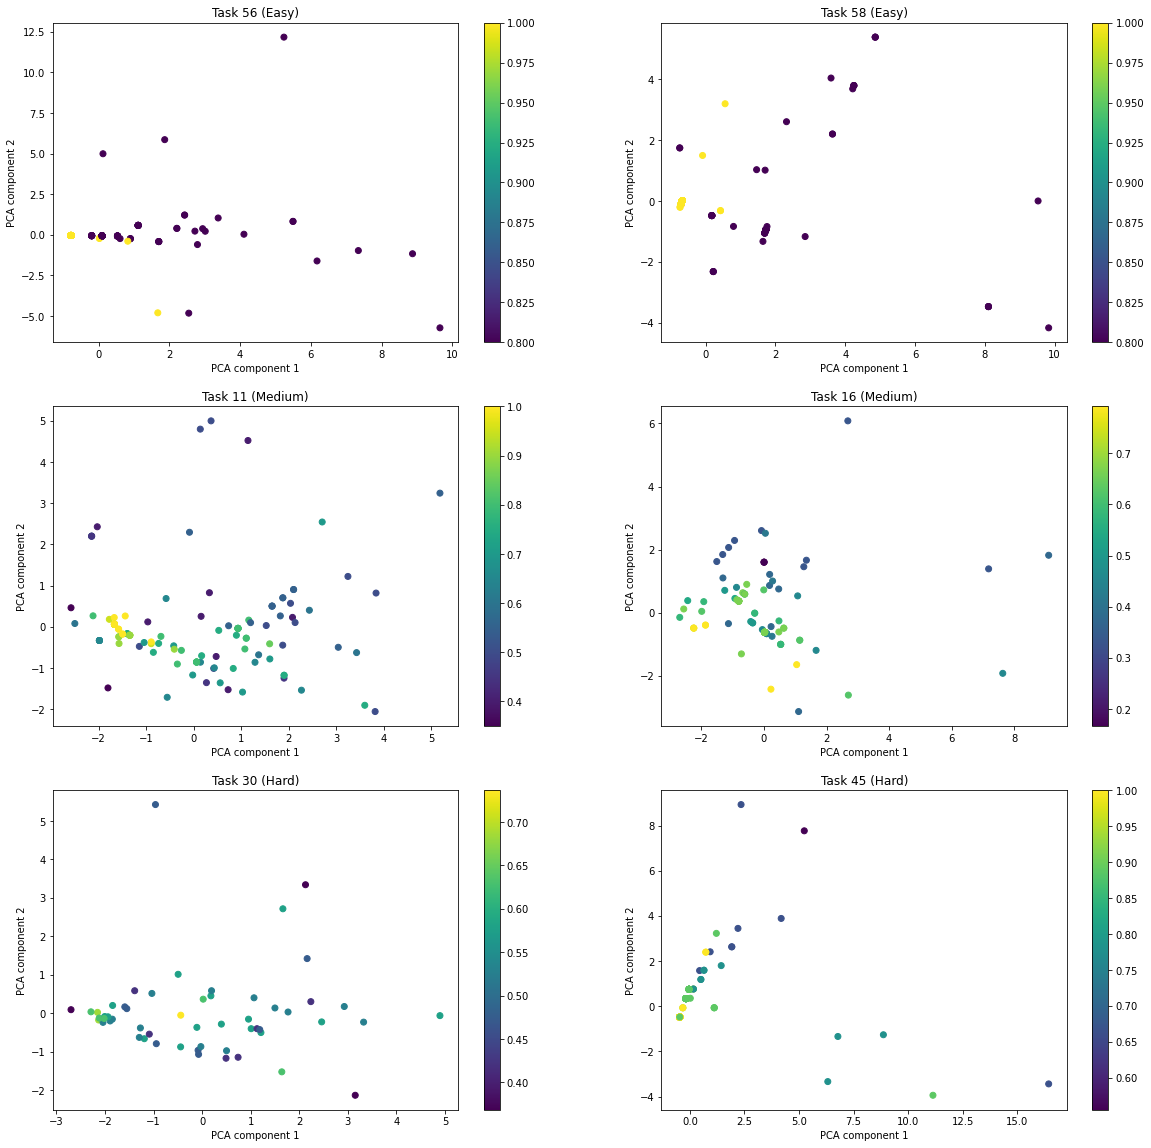

In [71]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 20))

for item, dif, plt_row, plt_col in zip([56, 58, 11, 16, 30, 45],
                                       ["Easy", "Easy", "Medium", "Medium", "Hard", "Hard"],
                                       [0, 0, 1, 1, 2, 2],
                                       [0, 1, 0, 1, 0, 1]):
    task_df = compute_features(item, correct_only=True)
            
    # Drop unnecessary columns
    task_df_trimmed = task_df.drop(['id', 'item', 'user', 'time', 'answer', 'code', 'moves', 'responseTime', 
                                    'correct', 'codeLength', 'sim_perc_sol', 'sim_perc_closest'],
                                    axis=1)
    
    # Scale the columns and perform pca
    pca_components = pca.fit_transform(scaler.fit_transform(task_df_trimmed[[x for x in task_df_trimmed.columns]]))
    
    # Plot
    ax = axes[plt_row, plt_col]
    im = ax.scatter(*pca_components.T[:2], c=task_df['sim_perc_sol'])
    ax.set_title("Task {} ({})".format(item, dif))
    ax.set_ylabel('PCA component 2')
    ax.set_xlabel('PCA component 1')
    fig.colorbar(im, ax=ax)

plt.show()

## Most frequent solutions

Top 3

[56, 58, 11, 16, 30, 45]

In [111]:
item = 16
task_df = compute_features(item, correct_only=True)

# Drop unnecessary columns
task_df_trimmed = task_df.drop(['id', 'item', 'user', 'time', 'answer', 'code', 'moves', 'responseTime', 
                                'correct', 'codeLength', 'sim_perc_closest'],
                                axis=1)

top_3_df = task_df_trimmed.groupby(task_df_trimmed.columns.tolist(),as_index=False).size().reset_index().\
      rename(columns={0:'count'}).sort_values(by=['count'], ascending=False).reset_index(drop=True).head(3)

print("Task", item)
print(top_3_df)

top_3_df = top_3_df.drop(['count'], axis=1)

Task 16
   sim_perc_sol  ast_len  def  print  loop  ifelse  math  compare  assign  \
0      0.666667       29    1      0     1       1     5        1       2   
1      0.666667       22    1      0     1       1     3        1       3   
2      0.625000       29    1      0     1       1     5        1       2   

   count  
0     22  
1      9  
2      5  


In [112]:
top_3_df.loc[[0]]

,sim_perc_sol,ast_len,def,print,loop,ifelse,math,compare,assign
0,0.666667,29,1,0,1,1,5,1,2


In [113]:
most_freq_1 = pd.merge(task_df, top_3_df.loc[[0]], how='inner', on=top_3_df.columns.tolist())
most_freq_2 = pd.merge(task_df, top_3_df.loc[[1]], how='inner', on=top_3_df.columns.tolist())
most_freq_3 = pd.merge(task_df, top_3_df.loc[[2]], how='inner', on=top_3_df.columns.tolist())

In [114]:
most_freq_1.code.values

array(['def max_pair_sum(num_list):\n    maximum = 0\n    for i in range(len(num_list)-1):\n        if num_list[i] + num_list[i+1] > maximum:\n            maximum = num_list[i] + num_list[i+1]\n    return maximum\n',
       'def max_pair_sum(num_list):\n    soucet=0\n    for i in range(len(num_list)-1):\n        if num_list[i]+num_list[i+1]>soucet:\n            soucet=num_list[i]+num_list[i+1]\n    return soucet\n',
       'def max_pair_sum(num_list):\n    count=0\n    for i in range(len(num_list)-1):\n        if (num_list[i]+num_list[i+1])>count:\n            count=num_list[i]+num_list[i+1]\n    return count\n',
       'def max_pair_sum(num_list):\n    max_sum = 0\n    for i in range(len(num_list)-1):\n        if num_list[i]+num_list[i+1] > max_sum:\n            max_sum = num_list[i]+num_list[i+1]\n    return max_sum\n',
       'def max_pair_sum(num_list):\n    highest = 0\n    for i in range(len(num_list)-1):\n        if (num_list[i] + num_list[i+1]) > highest:\n        \thighest = (

In [115]:
most_freq_2.code.values

array(['def max_pair_sum(num_list):\n    tmp_max = 0\n    for i in range(len(num_list)-1):\n        total = num_list[i] + num_list[i+1]\n        if total > tmp_max:\n            tmp_max = total\n    return tmp_max\n',
       'def max_pair_sum(num_list):\n    nej = 0\n    for i in range(len(num_list)-1):\n        v = num_list[i] + num_list[i + 1]\n        if v > nej:\n            nej = v\n    return nej\n',
       'def max_pair_sum(num_list):\n    new = 0\n    for i in range(len(num_list)-1):\n        sumn = num_list[i] + num_list[i+1]\n        if sumn > new:\n            new = sumn\n    return new\n',
       'def max_pair_sum(num_list):\n    n = 0\n    for i in range(len(num_list)-1):\n        s = num_list[i] + num_list[i + 1]\n        if s > n:\n            n = s\n    return n\n',
       'def max_pair_sum(num_list):\n    nejvyssi=0\n    for i in range(len(num_list)-1):\n        soucet=num_list[i]+num_list[i+1]\n        if soucet>nejvyssi:\n            nejvyssi=soucet\n    return nejvy

In [116]:
most_freq_3.code.values

array(['def max_pair_sum(num_list):\n    maxpair = 0\n    for i in range(1, len(num_list)-1):\n        if num_list[i] + num_list[i+1] > maxpair:\n            maxpair = num_list[i] + num_list[i+1]\n    return maxpair\n',
       'def max_pair_sum(num_list):\n    max_sum = 0\n    for i in range(0, (len(num_list)-1)):\n        if max_sum < num_list[i] + num_list[i+1]:\n            max_sum = num_list[i] + num_list[i+1]\n    return max_sum',
       'def max_pair_sum(num_list):\n    maximum = 0\n    for i in range(0,len(num_list)-1):\n        if (num_list[i] + num_list[i+1]) > maximum:\n            maximum = num_list[i] + num_list[i+1]\n    return maximum\n',
       'def max_pair_sum(num_list):\n    maximum = 0\n    for i in range(0,len(num_list)-1):\n        if (num_list[i]+num_list[i+1])>maximum:\n            maximum = num_list[i]+num_list[i+1]\n    return maximum',
       'def max_pair_sum(num_list):\n    maximum = 0\n    for i in range(0,len(num_list)-1):\n        if (num_list[i]+num_list

In [117]:
solution = questions_df.at[item, 'solution'][2:-2].split(',')[1].replace('"', '')
solution = decode_program(solution)
solution

'def max_pair_sum(num_list):\n    m = 0\n    for i in range(len(num_list)-1):\n        m = max(m, num_list[i] + num_list[i+1])\n    return m    \n'

## Most frequent mistakes / bad solutions

In [118]:
item = 16
task_df = compute_features(item, incorrect_only=True)

# Drop unnecessary columns
task_df_trimmed = task_df.drop(['id', 'item', 'user', 'time', 'answer', 'code', 'moves', 'responseTime', 
                                'correct', 'codeLength', 'sim_perc_sol'],
                                axis=1)

top_3_df = task_df_trimmed.groupby(task_df_trimmed.columns.tolist(),as_index=False).size().reset_index().\
      rename(columns={0:'count'}).sort_values(by=['count'], ascending=False).reset_index(drop=True).head(3)

print("Task", item)
print(top_3_df)

top_3_df = top_3_df.drop(['count'], axis=1)

Task 16
   ast_len  sim_perc_closest  def  print  loop  ifelse  math  compare  assign  \
0       26          0.461538    1      0     1       1     4        1       2   
1       10          0.600000    1      1     1       0     1        0       1   
2       29          0.137931    1      0     0       0     6        0       6   

   count  
0      5  
1      2  
2      2  


In [119]:
most_freq_1 = pd.merge(task_df, top_3_df.loc[[0]], how='inner', on=top_3_df.columns.tolist())
most_freq_2 = pd.merge(task_df, top_3_df.loc[[1]], how='inner', on=top_3_df.columns.tolist())
most_freq_3 = pd.merge(task_df, top_3_df.loc[[2]], how='inner', on=top_3_df.columns.tolist())

In [120]:
most_freq_1.code.values

array(['def max_pair_sum(num_list):\n    s = 0\n    for i in range(0, len(num_list)):\n        if num_list[i] + num_list[i+2] > s:\n            s = num_list[i] + num_list[i+2]\n    return s',
       'def max_pair_sum(num_list):\n    s = 0\n    for i in range(0, len(num_list)):\n        if num_list[i] + num_list[i+1] > s:\n            s = num_list[i] + num_list[i+2]\n    return s',
       'def max_pair_sum(num_list):\n    s = 0\n    for i in range(0, len(num_list)):\n        if num_list[i] + num_list[i + 1] > s:\n            s = num_list[i] + num_list[i + 1]\n    return s',
       'def max_pair_sum(num_list):\n    max_sum = 0\n    for i in range(len(num_list)):\n        if (num_list[i] + num_list[i-1]) > max_sum:\n            max_sum = num_list[i] + num_list[i-1]\n    return max_sum',
       'def max_pair_sum(num_list):\n    max_sum = 0\n    for i in range(len(num_list)):\n        if (num_list[i] + num_list[i-1]) > max_sum:\n            max_sum = (num_list[i] + num_list[i-1])\n    retur

In [121]:
most_freq_2.code.values

array(['def max_pair_sum(num_list):\n    x = []\n    for i in num_list:\n        x.append(i)\n    print(max(x)+i+5)\n    #return 0\n',
       'def max_pair_sum(num_list):\n    x = []\n    for i in num_list:\n        x.append(i)\n    print(max(x)+i+1)\n    #return 0\n'],
      dtype=object)

In [122]:
most_freq_3.code.values

array(['def max_pair_sum(num_list):\n    x=num_list[0]+num_list[1]\n    y=num_list[1]+num_list[2]\n    z=num_list[2]+num_list[3]\n    u=num_list[3]+num_list[4]\n    q=num_list[4]+num_list[5]\n    #p=num_list[5]+num_list[6]\n    return(max(x,y,z,u,q))\n',
       'def max_pair_sum(num_list):\n    x=num_list[0]+num_list[1]\n    y=num_list[1]+num_list[2]\n    z=num_list[2]+num_list[3]\n    u=num_list[3]+num_list[4]\n    q=num_list[4]+num_list[5]\n    #p=num_list[5]+num_list[6]\n    return(max(x,y,z,u,q))\n    \n'],
      dtype=object)

# TODO

Zistiť, u ktorých úloh sú riešenia blízko vzorovému a u ktorých nie - tie sú možno ťažšie?

Zistiť, u ktorých úloh sa často vyskytuje nejaká skupina zlých riešení - časté chyby.

## Poznámky

Prefiltroval som duplikáty (tie isté odovzdania od toho istého človeka). U niektorých úloh by sa dalo diskutovať, či sú rozlišné riešenia podľa môjho feature vektoru skutočne odlišné (úloha 45?)